# Unit 5 - Financial Planning

In [76]:
# Initial imports
import requests as req
import pandas as pd
from alpaca_trade_api import TimeFrame, REST
from MCForecastTools import MCSimulation

%matplotlib inline

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [40]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [41]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [42]:
# Fetch current BTC price
response = req.get(btc_url)
btc_data = response.json()
btc_price = btc_data['data']['1']['quotes']['CAD']['price']

# Fetch current ETH price
response = req.get(eth_url)
eth_data = response.json()
eth_price = eth_data['data']['1027']['quotes']['CAD']['price']

# Compute current value of my crypto
my_btc_value = my_btc * btc_price
my_eth_value = my_eth * eth_price

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $60486.12
The current value of your 5.3 ETH is $19892.53


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [43]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [44]:
# Create the Alpaca API object
apca = REST()

In [45]:
# Format current date as ISO format
yesterday = pd.Timestamp.now(tz="America/New_York") - pd.Timedelta(days=1)

start = (yesterday - pd.Timedelta(days=1460)).strftime('%Y-%m-%d')
end = yesterday.strftime('%Y-%m-%d')

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to '1D' for Alpaca API
timeframe = "1DAY"

# Get current closing prices for SPY and AGG
df_tickers = apca.get_bars(tickers, TimeFrame.Day, start, end).df

# Preview DataFrame
df_tickers.head()


,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,
2018-04-23 04:00:00+00:00,105.98,106.01,105.90,105.95,2620804,11475,105.953540,AGG
2018-04-24 04:00:00+00:00,105.85,105.92,105.78,105.81,3442319,16110,105.846798,AGG
2018-04-25 04:00:00+00:00,105.72,105.74,105.60,105.67,3984953,13988,105.715560,AGG
2018-04-26 04:00:00+00:00,105.83,105.90,105.76,105.85,4870388,13589,105.829017,AGG
2018-04-27 04:00:00+00:00,105.96,106.04,105.94,105.98,3806396,9173,105.988632,AGG


In [46]:
# Pick AGG and SPY close prices
df_closing_prices = pd.DataFrame()
df_closing_prices = pd.pivot_table(df_tickers, values='close', columns='symbol', index=df_tickers.index)
df_closing_prices.sort_values(by='timestamp', ascending=False, inplace=True)

df_closing_prices.index = pd.to_datetime(df_closing_prices.index.strftime('%Y-%m-%d'))
df_closing_prices.index.name = 'date'
df_closing_prices.columns = ['AGG', 'SPY']

agg_close_price, spy_close_price = df_closing_prices.iloc[0]

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $103.04
Current SPY closing price: $438.06


In [47]:
# Compute the current value of shares
my_spy_value = my_spy * spy_close_price
my_agg_value = my_agg * agg_close_price

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $21903.00
The current value of your 200 AGG shares is $20608.00


### Savings Health Analysis

In [48]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
df_savings = pd.DataFrame(
  {
    'amount': [
      my_btc_value + my_eth_value,
      my_spy_value + my_agg_value
    ]
  }, 
  index=['crypto', 'shares']
)

# Display savings DataFrame
df_savings.head()

,amount
crypto,80378.654354
shares,42511.000000


array([<AxesSubplot:ylabel='amount'>], dtype=object)

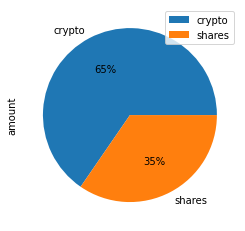

In [49]:
# Plot savings pie chart
df_savings.plot.pie(labels=['crypto', 'shares'], autopct='%.0f%%', subplots=True)

In [50]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = df_savings.iloc[:, 0].sum()
total_savings = round(total_savings, 2)

# Validate saving health
if total_savings > emergency_fund:
  print(f"Congratulations! You have enough money in this fund.")
elif total_savings == emergency_fund:
  print(f"You have exactly enough savings! Congratulations on reaching this financial goal.")
else:
  print(f"Almost there! You are {emergency_fund - total_savings} away from reaching this financial goal.")

Congratulations! You have enough money in this fund.


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [51]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
yesterday = pd.Timestamp.now(tz="America/New_York") - pd.Timedelta(days=1)

start = (yesterday - pd.Timedelta(days=365*5)).strftime('%Y-%m-%d')
end = yesterday.strftime('%Y-%m-%d')

In [52]:
# Get 5 years' worth of historical data for SPY and AGG
# (use a limit=1000 parameter to call the most recent 1000 days of data)
df_stock_data = apca.get_bars(tickers, TimeFrame.Day, start, end, adjustment='raw').df
df_stock_data.index = pd.DatetimeIndex(df_stock_data.index.date, name='date')

df_stock_data = df_stock_data[['close', 'symbol']]
df_stock_data = pd.pivot_table(df_stock_data, values='close', columns='symbol', index=df_stock_data.index)

multi_index_columns = pd.MultiIndex.from_tuples(
  [(ticker, "close") for ticker in tickers]
)

df_stock_data.columns = multi_index_columns
df_stock_data

# Display sample data
df_stock_data.head()

,AGG,SPY
,close,close
date,,
2017-04-24,109.18,237.17
2017-04-25,108.82,238.55
2017-04-26,108.96,238.40
2017-04-27,109.06,238.60
2017-04-28,109.25,238.08


In [53]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_thirtyyear = MCSimulation(
  portfolio_data = df_stock_data,
  weights = [.40,.60],
  num_simulation = 500,
  num_trading_days = 252*30
)

In [54]:
# Printing the simulation input data
df_stock_data.head()

,AGG,SPY
,close,close
date,,
2017-04-24,109.18,237.17
2017-04-25,108.82,238.55
2017-04-26,108.96,238.40
2017-04-27,109.06,238.60
2017-04-28,109.25,238.08


In [57]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_thirtyyear.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.007875,0.994717,0.996652,1.005092,0.999925,1.002554,0.989970,0.997209,0.995667,0.993126,...,0.993092,1.005170,0.995859,0.992622,1.011765,1.012767,1.023599,0.990723,1.000214,1.008186
2,1.023815,0.979873,0.997831,1.003736,0.989561,1.003376,0.987890,0.988854,0.993288,0.998471,...,0.995811,1.003288,0.997057,0.981850,1.006798,1.026072,1.014824,0.994484,1.014006,1.008014
3,1.009160,0.972044,0.998838,1.008746,0.978788,1.000904,0.983041,0.990805,0.999247,0.998173,...,0.991554,0.999930,0.998706,0.981251,1.014114,1.029001,1.014547,0.999911,1.004635,1.013815
4,1.003375,0.961657,1.000964,1.021114,0.975670,1.004329,0.984479,0.999934,1.009091,0.999288,...,0.988127,1.001109,0.990562,0.980085,1.002523,1.030143,1.020042,1.001132,0.992500,1.014394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,9.414001,3.842803,10.641276,16.218515,8.640286,31.123060,4.271857,29.437940,7.243875,2.870255,...,8.785396,4.478131,7.676828,9.532752,6.550597,2.024691,4.378252,8.203479,7.776899,3.740661
7557,9.275151,3.857040,10.642430,16.167681,8.751759,30.983772,4.248663,29.622765,7.205423,2.871968,...,8.748801,4.447899,7.665902,9.568951,6.574195,2.018098,4.377856,8.135941,7.712407,3.808168
7558,9.242721,3.883234,10.636497,16.214236,8.842629,30.990712,4.197018,29.353061,7.167961,2.871120,...,8.707915,4.448923,7.768801,9.451219,6.509955,2.011160,4.345987,8.113144,7.726472,3.830629
7559,9.172286,3.887944,10.538599,16.052955,8.874929,30.773818,4.159165,29.528277,7.028552,2.897621,...,8.773101,4.436369,7.797311,9.442880,6.499909,2.016738,4.311741,8.200099,7.733388,3.829451


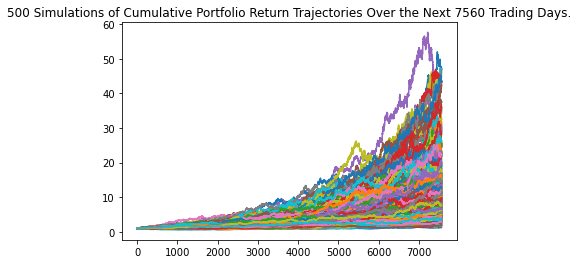

In [58]:
# Plot simulation outcomes
line_plot = MC_thirtyyear.plot_simulation()

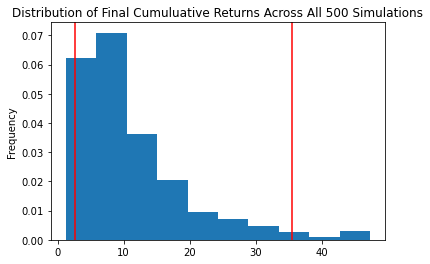

In [59]:
# Plot probability distribution and confidence intervals
dist_plot = MC_thirtyyear.plot_distribution()

### Retirement Analysis

In [60]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_stats = MC_thirtyyear.summarize_cumulative_return()

# Print summary statistics
print(summary_stats)

count           500.000000
mean             11.033681
std               8.357423
min               1.247331
25%               5.450098
50%               8.208772
75%              13.924686
max              47.235571
95% CI Lower      2.632999
95% CI Upper     35.493324
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [61]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(summary_stats[8]*initial_investment,2)
ci_upper = round(summary_stats[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $52659.97 and $709866.49


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [62]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(summary_stats[8]*initial_investment,2)
ci_upper = round(summary_stats[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${int(initial_investment)} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000 in the portfolio over the next 30 years will end within in the range of $78989.96 and $1064799.73


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [63]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_fiveyear = MCSimulation(
  portfolio_data = df_stock_data,
  weights = [.40,.60],
  num_simulation = 500,
  num_trading_days = 252*5
)

In [77]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_fiveyear.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.009159,1.001486,0.997737,1.002011,1.001539,0.990146,0.990678,1.000432,0.995300,0.994266,...,1.012740,0.997453,0.984563,1.000325,0.992148,1.002226,0.992744,1.018185,0.994034,1.004812
2,1.019612,1.006094,0.992414,0.997041,1.016474,1.001476,0.986698,1.004393,0.984932,0.979219,...,1.021214,0.995638,0.983159,1.007234,1.006031,1.000047,1.008970,1.018636,1.002323,1.009075
3,1.019021,0.997866,0.983200,1.003559,1.017054,0.996372,0.981493,1.003749,1.001333,0.967209,...,1.012702,0.987066,0.980192,1.017292,0.994583,1.002001,0.998644,1.023598,0.995784,1.016778
4,1.022346,0.991193,0.970899,1.001835,1.019165,1.004003,0.978110,1.004995,0.999437,0.964625,...,1.009149,0.985031,1.001434,1.009709,0.983672,1.003505,1.004665,1.041544,0.996326,1.007216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.651127,1.104504,0.917418,1.189521,1.185848,0.907238,1.344937,1.579989,1.299695,1.413296,...,2.291254,1.228680,0.866220,1.058393,1.314464,1.281090,1.571495,1.533573,1.839433,1.495204
1257,1.656994,1.103482,0.909860,1.175337,1.177428,0.914413,1.346450,1.581631,1.303360,1.392679,...,2.305576,1.242411,0.878553,1.054199,1.325851,1.304054,1.597144,1.519299,1.830794,1.488721
1258,1.650918,1.102582,0.903688,1.188448,1.188129,0.907472,1.351720,1.578099,1.299615,1.413094,...,2.299123,1.233790,0.870077,1.051034,1.340770,1.318222,1.634346,1.528001,1.824863,1.491667
1259,1.648708,1.103921,0.901561,1.188127,1.188319,0.899580,1.359093,1.565750,1.281752,1.406341,...,2.284880,1.235653,0.875817,1.044793,1.344909,1.322169,1.660667,1.527061,1.830129,1.491037


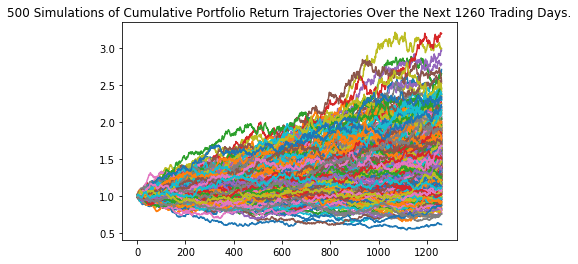

In [65]:
# Plot simulation outcomes
line_plot = MC_fiveyear.plot_simulation()

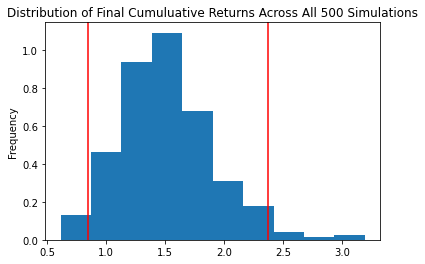

In [66]:
# Plot probability distribution and confidence intervals
dist_plot = MC_fiveyear.plot_distribution()

In [67]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_stats = MC_fiveyear.summarize_cumulative_return()

# Print summary statistics
print(summary_stats)

count           500.000000
mean              1.515163
std               0.396993
min               0.610872
25%               1.243524
50%               1.479090
75%               1.745344
max               3.195873
95% CI Lower      0.841545
95% CI Upper      2.373158
Name: 1260, dtype: float64


In [68]:
# Set initial investment
initial_investment = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five = round(summary_stats[8]*initial_investment,2)
ci_upper_five = round(summary_stats[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 5 years will end within in the range of $50492.68 and $142389.51


### Ten Years Retirement Option

In [69]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
MC_tenyear = MCSimulation(
  portfolio_data = df_stock_data,
  weights = [.40,.60],
  num_simulation = 500,
  num_trading_days = 252*10
)

In [79]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_tenyear.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.996973,0.990702,0.996851,1.004461,0.999155,0.995909,1.004572,0.999457,0.998956,0.985431,...,1.003519,0.998576,0.994383,0.996607,1.002555,1.017163,1.006337,0.997394,0.997889,0.996511
2,1.009150,0.989371,1.002530,1.012211,0.995078,0.985230,0.998126,1.005286,1.002472,0.988318,...,0.995967,1.003812,0.989895,0.995703,1.001700,1.009211,1.003694,1.000523,1.007224,0.999643
3,1.004336,0.977999,1.001405,1.024645,0.995546,0.998054,1.006074,1.004277,0.988306,0.990367,...,0.997417,1.002428,0.989177,0.995960,1.005480,1.020558,0.998717,0.991650,0.997899,0.998909
4,1.023989,0.980078,1.001383,1.025581,0.996721,0.988897,1.027242,0.998598,0.994591,0.999326,...,0.995344,1.006337,0.994049,0.988401,1.006588,1.012150,1.008616,0.983807,0.998884,1.004120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,2.772341,3.607471,1.651966,3.411627,2.909133,1.753309,5.273227,1.318760,1.396761,3.672156,...,2.748881,3.728692,1.776786,3.121573,2.634626,3.474752,1.915230,2.019231,1.782593,1.361464
2517,2.792939,3.592187,1.638894,3.413996,2.918878,1.758782,5.300134,1.331577,1.403674,3.702261,...,2.754990,3.709032,1.785310,3.164270,2.633865,3.436416,1.922911,1.994776,1.788144,1.349832
2518,2.763974,3.634818,1.639238,3.374107,2.944402,1.751231,5.309583,1.335039,1.415493,3.726298,...,2.736516,3.695662,1.770086,3.173217,2.639695,3.471892,1.902744,2.016963,1.791319,1.362857
2519,2.772937,3.589180,1.650735,3.392316,2.935738,1.725710,5.283864,1.334569,1.405494,3.733300,...,2.729325,3.754521,1.785414,3.175139,2.648112,3.509310,1.890211,2.013939,1.819652,1.382264


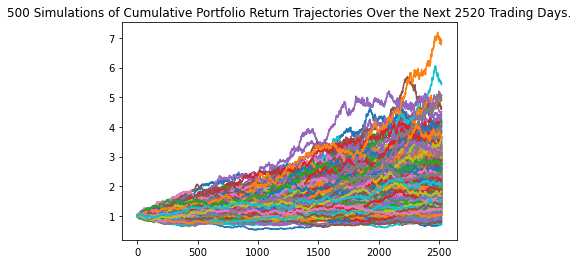

In [71]:
# Plot simulation outcomes
line_plot = MC_tenyear.plot_simulation()

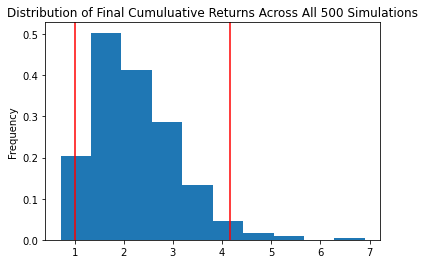

In [72]:
# Plot probability distribution and confidence intervals
dist_plot = MC_tenyear.plot_distribution()

In [73]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_stats = MC_tenyear.summarize_cumulative_return()

# Print summary statistics
print(summary_stats)

count           500.000000
mean              2.229220
std               0.855731
min               0.712961
25%               1.592158
50%               2.085196
75%               2.740781
max               6.905930
95% CI Lower      1.000891
95% CI Upper      4.167085
Name: 2520, dtype: float64


In [74]:
# Set initial investment
initial_investment = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_ten = round(summary_stats[8]*initial_investment,2)
ci_upper_ten = round(summary_stats[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 10 years will end within in the range of $60053.45 and $250025.1
